
# Spotify Songs Analysis — Internship Notebook

> **Goal:** Explore trends in **popularity**, **danceability**, **energy**, **tempo**, and **genre** with a Spotify-like dataset.  
> **Tools:** Pandas + Matplotlib (no seaborn), Jupyter Lab

<div style="margin-top:1rem; padding:1rem 1.25rem; border-radius:16px; background: rgba(17, 24, 39, 0.72); border:1px solid rgba(148,163,184,0.15); color:#e5e7eb;">
<style>
  :root { --muted:#94a3b8; --text:#e5e7eb; --accent:#38bdf8; }
  .theory p, .theory li { color: var(--text); }
  .muted { color: var(--muted); }
  code { background:#0b1220; padding:0.15rem 0.35rem; border-radius:6px; border:1px solid rgba(148,163,184,0.2); }
</style>
<div class="theory">
  <h2 style="background: linear-gradient(90deg, var(--accent), #a78bfa); -webkit-background-clip:text; background-clip:text; color:transparent;">Theory & Method</h2>
  <ul>
    <li>External CSV: <code>spotify_songs_raw.csv</code> with metadata + audio features.</li>
    <li>Cleaning: trim whitespace, standardize genres, parse dates, coerce numeric types, clip ranges.</li>
    <li>Impute: median for <code>popularity</code>; drop rows missing core features.</li>
    <li>EDA: distributions, scatter (danceability vs energy), yearly trends, genre stats.</li>
  </ul>
</div>
</div>


In [1]:

%matplotlib inline
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

RAW_PATH = "spotify_songs_raw.csv"
CLEAN_PATH = "spotify_songs_clean.csv"
FIG_DIR = "spotify_figures"
os.makedirs(FIG_DIR, exist_ok=True)


## 1) Load Raw Data

In [2]:

df_raw = pd.read_csv(RAW_PATH)
print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (400, 22)


,track_id,track_name,artist_name,album_name,release_date,year,duration_ms,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,key,mode,time_signature,genre,explicit
0,trk_00000,Midnight Dreams,Aurora Lane,Stories Vol. 8,2009-11-27,2009,163050,22.0,0.121941,0.728289,...,0.184495,0.185300,0.353401,0.490782,131.912873,5,0,7,indie,False
1,trk_00001,Digital Hearts,Tarek Ali,Diary Vol. 8,1992-05-10,1992,139120,NaN,0.238861,0.440888,...,0.467405,0.408321,0.134074,0.917124,117.897630,6,1,4,indie,False
2,trk_00002,Silent Gravity,El Tigre,Diary Vol. 2,2004-10-04,2004,212443,47.0,0.404486,0.089985,...,0.245596,0.145800,0.501737,0.327029,151.057196,8,0,3,afrobeats,False
3,trk_00003,Lonely Lines,VELVET STREET,Diary Vol. 4,2004-03-19,2004,194616,93.0,0.836340,0.171266,...,0.192964,0.139853,0.222874,0.764449,106.715451,2,0,7,house,False
4,trk_00004,Crystal Lines,Tarek Ali,Diary Vol. 1,2022-10-04,2022,257603,32.0,0.782253,0.879026,...,0.302548,0.373561,0.361178,0.782035,104.035296,3,1,5,afrobeats,False


## 2) Clean the Data

In [3]:

df = df_raw.copy()

# Trim whitespace
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype(str).str.strip().replace({"None": np.nan, "nan": np.nan})

# Parse release_date -> year
def parse_date_safe(x):
    try:
        return pd.to_datetime(x, errors="coerce")
    except Exception:
        return pd.NaT

if "release_date" in df.columns:
    df["release_date"] = df["release_date"].apply(parse_date_safe)
else:
    df["release_date"] = pd.NaT

if "year" in df.columns:
    df["year"] = np.where(df["release_date"].notna(), df["release_date"].dt.year, df["year"])
else:
    df["year"] = df["release_date"].dt.year

# Standardize strings & genres
for col in ["track_name","artist_name","album_name","genre"]:
    if col in df.columns:
        df[col] = df[col].where(df[col].notna(), None)
        if col == "genre":
            df[col] = df[col].str.lower().str.replace(r"\s+", " ", regex=True)
        else:
            df[col] = df[col].str.replace(r"\s+", " ", regex=True).str.strip()

genre_map = {"hiphop":"hip hop","hip-hop":"hip hop","rnb":"r&b","lofi":"lo-fi","electronic":"edm"}
if "genre" in df.columns:
    df["genre"] = df["genre"].replace(genre_map).fillna("unknown")

# Coerce numeric
num_cols = ["popularity","danceability","energy","loudness","speechiness","acousticness",
            "instrumentalness","liveness","valence","tempo","duration_ms","key","mode","time_signature"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Impute & clip ranges
if "popularity" in df.columns:
    df["popularity"] = df["popularity"].fillna(df["popularity"].median(skipna=True))

for b in ["danceability","energy","speechiness","acousticness","instrumentalness","liveness","valence"]:
    if b in df.columns:
        df[b] = df[b].clip(0, 1)

if "tempo" in df.columns: df["tempo"] = df["tempo"].clip(40, 240)
if "loudness" in df.columns: df["loudness"] = df["loudness"].clip(-60, 5)
if "duration_ms" in df.columns: df["duration_ms"] = df["duration_ms"].clip(30000, 600000)

# Drop rows missing core
required = ["track_name","artist_name","year","danceability","energy","tempo"]
df = df.dropna(subset=[c for c in required if c in df.columns])

print("Cleaned shape:", df.shape)
df.head()


Cleaned shape: (400, 22)


,track_id,track_name,artist_name,album_name,release_date,year,duration_ms,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,key,mode,time_signature,genre,explicit
0,trk_00000,Midnight Dreams,Aurora Lane,Stories Vol. 8,2009-11-27,2009,163050,22.0,0.121941,0.728289,...,0.184495,0.185300,0.353401,0.490782,131.912873,5,0,7,indie,False
1,trk_00001,Digital Hearts,Tarek Ali,Diary Vol. 8,1992-05-10,1992,139120,55.0,0.238861,0.440888,...,0.467405,0.408321,0.134074,0.917124,117.897630,6,1,4,indie,False
2,trk_00002,Silent Gravity,El Tigre,Diary Vol. 2,2004-10-04,2004,212443,47.0,0.404486,0.089985,...,0.245596,0.145800,0.501737,0.327029,151.057196,8,0,3,afrobeats,False
3,trk_00003,Lonely Lines,VELVET STREET,Diary Vol. 4,2004-03-19,2004,194616,93.0,0.836340,0.171266,...,0.192964,0.139853,0.222874,0.764449,106.715451,2,0,7,house,False
4,trk_00004,Crystal Lines,Tarek Ali,Diary Vol. 1,2022-10-04,2022,257603,32.0,0.782253,0.879026,...,0.302548,0.373561,0.361178,0.782035,104.035296,3,1,5,afrobeats,False


## 3) Save Cleaned Dataset

In [4]:

df.to_csv(CLEAN_PATH, index=False)
print("Saved:", CLEAN_PATH)


Saved: spotify_songs_clean.csv


## 4) Summary Tables

In [5]:

top_genres = (df["genre"].value_counts(dropna=False).head(15).rename_axis("genre").reset_index(name="count")
              if "genre" in df.columns else pd.DataFrame(columns=["genre","count"]))
top_genres


,genre,count
0,techno,31
1,folk,25
2,k-pop,25
3,rap,23
4,afrobeats,22
5,house,21
6,country,21
7,latin,19
8,blues,19
9,metal,19


In [6]:

cols = [c for c in ["popularity","danceability","energy","tempo"] if c in df.columns]
yearly = (df.groupby("year", as_index=False)[cols].mean().sort_values("year")
          if len(cols)>0 else pd.DataFrame())
yearly.head()


,year,popularity,danceability,energy,tempo
0,1990,55.100000,0.574713,0.438183,109.388016
1,1991,59.333333,0.288153,0.452920,114.966691
2,1992,56.066667,0.487529,0.592828,120.737681
3,1993,50.500000,0.481167,0.485067,123.185840
4,1994,63.785714,0.512162,0.498315,112.192549


## 5) Visualizations (Matplotlib only)

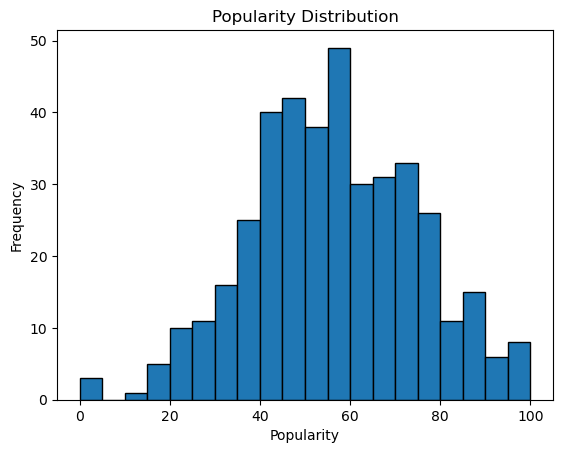

In [7]:

plt.figure()
if "popularity" in df.columns:
    df["popularity"].dropna().plot(kind="hist", bins=20, edgecolor="black")
    plt.title("Popularity Distribution"); plt.xlabel("Popularity"); plt.ylabel("Frequency")
    plt.savefig(os.path.join(FIG_DIR, "popularity_hist.png"), bbox_inches="tight")
    plt.show()
else:
    print("Column 'popularity' not found")


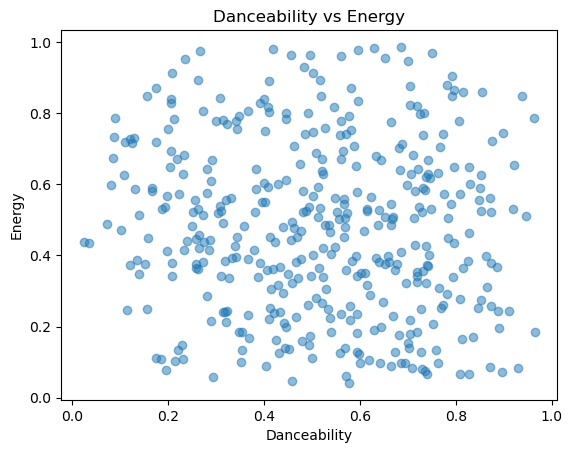

In [8]:

plt.figure()
if "danceability" in df.columns and "energy" in df.columns:
    plt.scatter(df["danceability"], df["energy"], alpha=0.5)
    plt.title("Danceability vs Energy"); plt.xlabel("Danceability"); plt.ylabel("Energy")
    plt.savefig(os.path.join(FIG_DIR, "danceability_vs_energy.png"), bbox_inches="tight")
    plt.show()
else:
    print("Required columns not found")


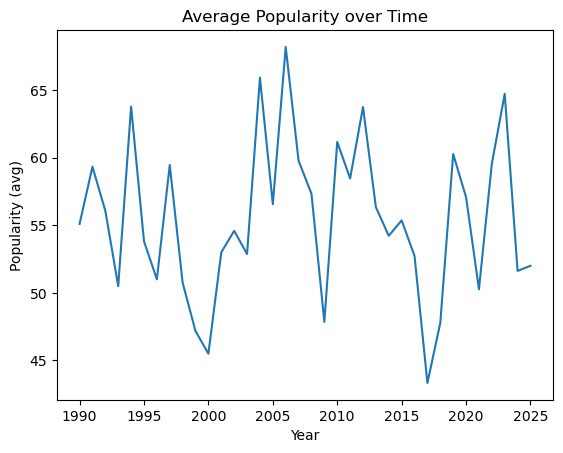

In [9]:

if not yearly.empty and "popularity" in yearly.columns:
    plt.figure(); plt.plot(yearly["year"], yearly["popularity"])
    plt.title("Average Popularity over Time"); plt.xlabel("Year"); plt.ylabel("Popularity (avg)")
    plt.savefig(os.path.join(FIG_DIR, "popularity_over_time.png"), bbox_inches="tight"); plt.show()


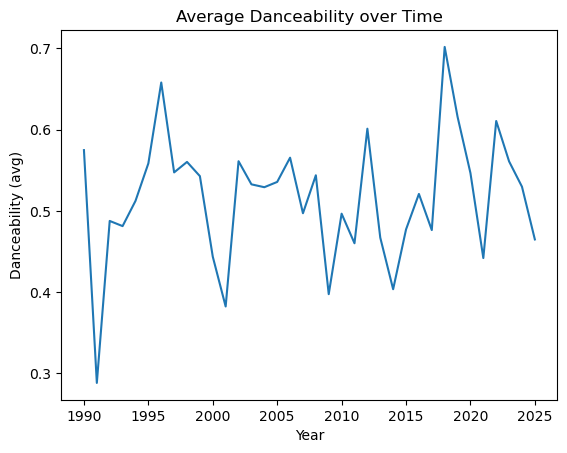

In [10]:

if not yearly.empty and "danceability" in yearly.columns:
    plt.figure(); plt.plot(yearly["year"], yearly["danceability"])
    plt.title("Average Danceability over Time"); plt.xlabel("Year"); plt.ylabel("Danceability (avg)")
    plt.savefig(os.path.join(FIG_DIR, "danceability_over_time.png"), bbox_inches="tight"); plt.show()


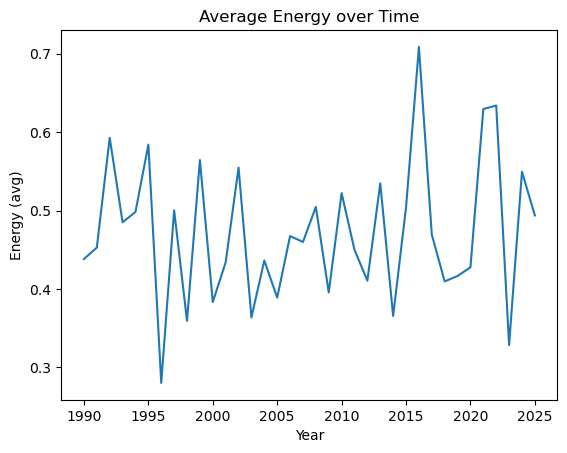

In [11]:

if not yearly.empty and "energy" in yearly.columns:
    plt.figure(); plt.plot(yearly["year"], yearly["energy"])
    plt.title("Average Energy over Time"); plt.xlabel("Year"); plt.ylabel("Energy (avg)")
    plt.savefig(os.path.join(FIG_DIR, "energy_over_time.png"), bbox_inches="tight"); plt.show()


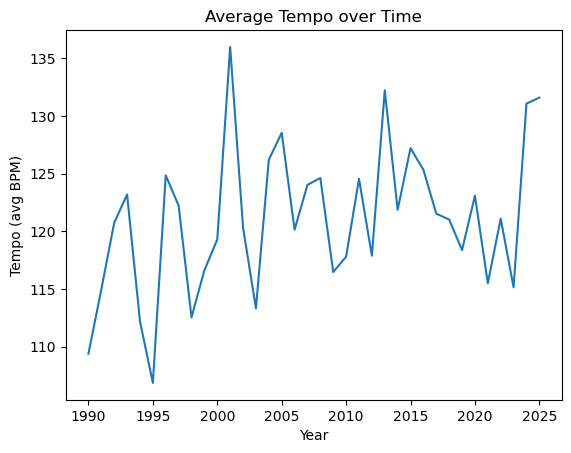

In [12]:

if not yearly.empty and "tempo" in yearly.columns:
    plt.figure(); plt.plot(yearly["year"], yearly["tempo"])
    plt.title("Average Tempo over Time"); plt.xlabel("Year"); plt.ylabel("Tempo (avg BPM)")
    plt.savefig(os.path.join(FIG_DIR, "tempo_over_time.png"), bbox_inches="tight"); plt.show()


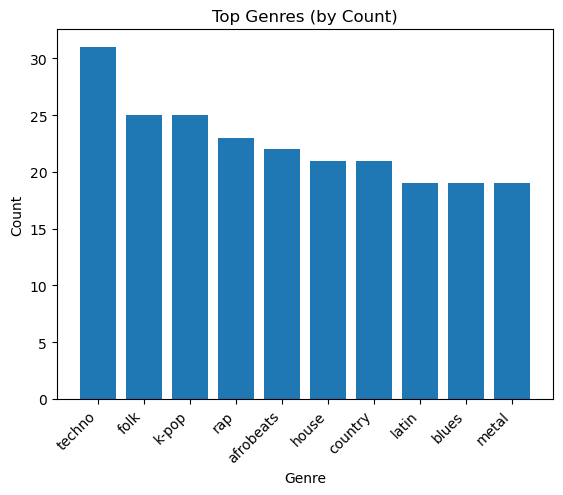

In [13]:

if not top_genres.empty:
    top10 = top_genres.head(10)
    plt.figure(); plt.bar(top10["genre"].astype(str), top10["count"])
    plt.title("Top Genres (by Count)"); plt.xlabel("Genre"); plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.savefig(os.path.join(FIG_DIR, "top_genres_count.png"), bbox_inches="tight"); plt.show()


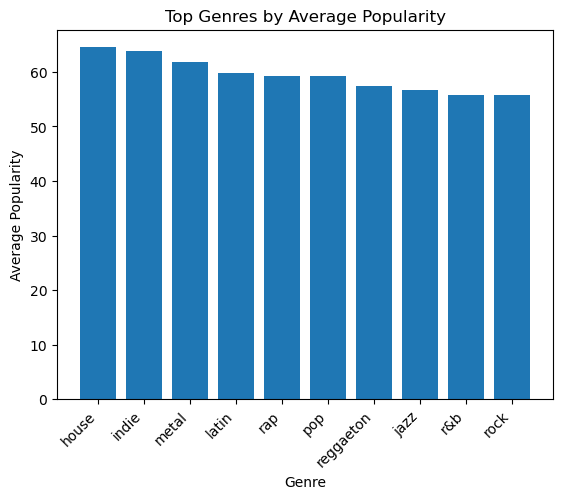

In [14]:

if "genre" in df.columns and "popularity" in df.columns:
    genre_pop = (df.groupby("genre")["popularity"].mean().sort_values(ascending=False).head(10).reset_index())
    plt.figure(); plt.bar(genre_pop["genre"].astype(str), genre_pop["popularity"])
    plt.title("Top Genres by Average Popularity"); plt.xlabel("Genre"); plt.ylabel("Average Popularity")
    plt.xticks(rotation=45, ha="right")
    plt.savefig(os.path.join(FIG_DIR, "top_genres_by_popularity.png"), bbox_inches="tight"); plt.show()


C:\Users\840 G6\AppData\Local\Temp\ipykernel_1688\1247915810.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(g) for g in top5], vert=True, patch_artist=False)


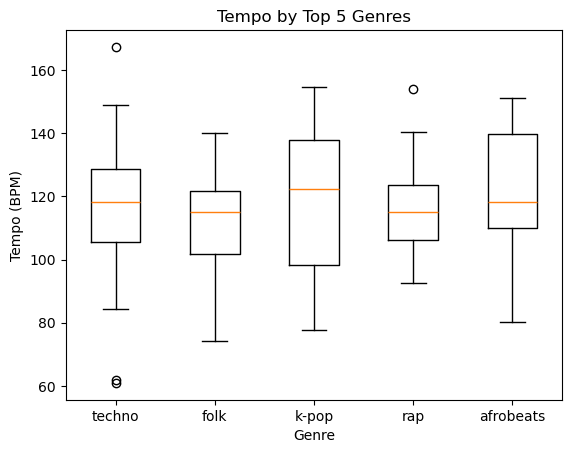

In [15]:

if "genre" in df.columns and "tempo" in df.columns:
    top5 = df["genre"].value_counts().head(5).index.tolist()
    df_top5 = df[df["genre"].isin(top5)]
    if not df_top5.empty:
        plt.figure()
        data = [df_top5[df_top5["genre"]==g]["tempo"].dropna() for g in top5]
        plt.boxplot(data, labels=[str(g) for g in top5], vert=True, patch_artist=False)
        plt.title("Tempo by Top 5 Genres"); plt.xlabel("Genre"); plt.ylabel("Tempo (BPM)")
        plt.savefig(os.path.join(FIG_DIR, "tempo_by_top5_genres.png"), bbox_inches="tight"); plt.show()


## 6) Quick Insights

In [16]:

insights = []
if 'genre' in df.columns and not df['genre'].empty:
    tg = df['genre'].value_counts().head(1)
    if not tg.empty:
        insights.append(f"Most frequent genre: {tg.index[0]} ({tg.iloc[0]} tracks).")
if 'danceability' in df.columns and 'energy' in df.columns:
    corr = df['danceability'].corr(df['energy'])
    insights.append(f"Danceability vs Energy correlation: {corr:.2f}.")
if 'tempo' in df.columns:
    insights.append(f"Tempo median: {df['tempo'].median():.1f} BPM.")
if 'popularity' in df.columns:
    insights.append(f"Average popularity: {df['popularity'].mean():.1f}.")
print("\n".join(insights) if insights else "Run previous cells first.")


Most frequent genre: techno (31 tracks).
Danceability vs Energy correlation: -0.09.
Tempo median: 119.9 BPM.
Average popularity: 55.8.
